In [6]:
# 1. Imports and Setup
import sys, os
sys.path.append(os.path.abspath(".."))
from notebook_setup import *
tracker = ExperimentTracker()

Checking dependencies in src/config.py...
  -> Chronos: True
  -> TimeGPT: True
  -> API Key: Found
Notebook setup complete.


Dataset: World Bank USA Real GDP Yearly
Total: 65 | Train: 59 | Test: 6
Train period: 1960-01-01 to 2018-01-01
Test period:  2019-01-01 to 2024-01-01
Seasonal period: 1


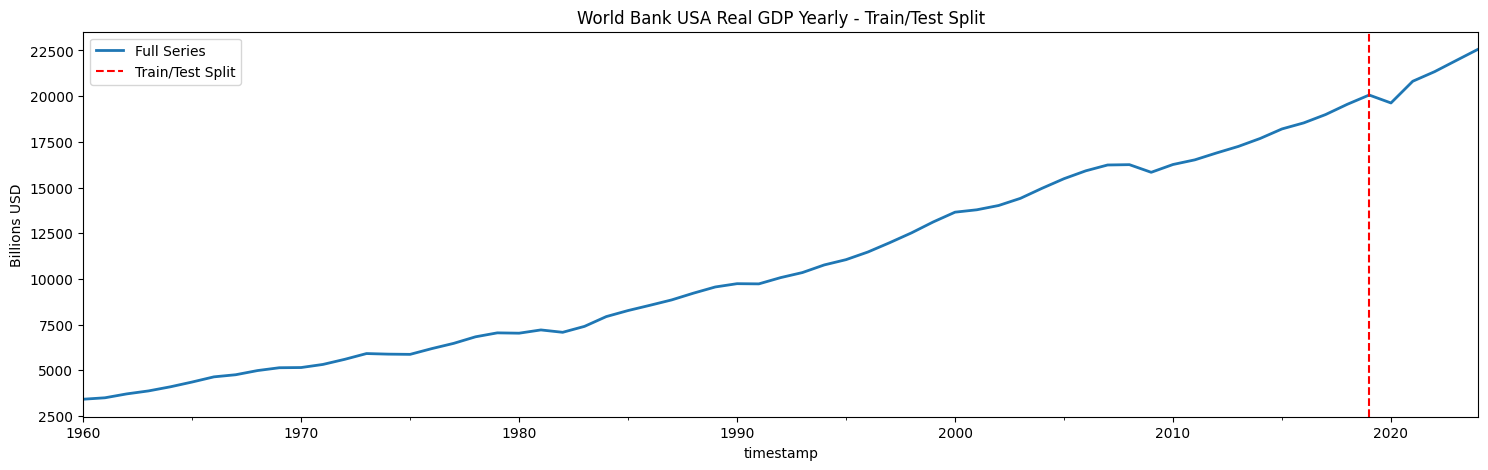

In [7]:
# 2. Data Loading and Configuration
#
# DATASET_CONFIG serves as a template for different datasets.
# Simply uncomment the desired configuration or create a new one.

# === ACTIVE DATASET CONFIGURATION ===
DATASET_CONFIG = {
    "file_path": "../datasets/wb_usa_real_gdp_yearly.csv",
    "time_column": "timestamp",
    "target_column": "real_gdp",
    "frequency": "YS",  # 'MS'=monthly start, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    "test_periods": 6,  # Number of periods to hold out for testing
    "seasonal_period": 1,  # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    "name": "World Bank USA Real GDP Yearly",
    "value_scale": 1e9,  # Scale factor for values (1e9 = billions)
    "value_unit": "Billions USD",
}

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])

# Scale values for better readability (e.g., to billions USD)
if "value_scale" in DATASET_CONFIG and DATASET_CONFIG["value_scale"] != 1:
    df[DATASET_CONFIG["target_column"]] = (
        df[DATASET_CONFIG["target_column"]] / DATASET_CONFIG["value_scale"]
    )

series = TimeSeries.from_dataframe(
    df, DATASET_CONFIG["time_column"], DATASET_CONFIG["target_column"]
)
series = series.astype(np.float32)

# === TRAIN/TEST SPLIT ===
# Test set is held out completely - models never see it during training or validation
freq = DATASET_CONFIG["frequency"]
test_periods = DATASET_CONFIG["test_periods"]
offset_map = {
    "MS": pd.DateOffset(months=test_periods),
    "QS": pd.DateOffset(months=test_periods * 3),
    "YS": pd.DateOffset(years=test_periods),
    "D": pd.DateOffset(days=test_periods),
    "H": pd.DateOffset(hours=test_periods),
}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# === SCALING (for Deep Learning models) ===
# IMPORTANT: Scaler is fitted ONLY on training data to prevent data leakage
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)  # Transform only, no fitting
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Train period: {train.start_time().date()} to {train.end_time().date()}")
print(f"Test period:  {test.start_time().date()} to {test.end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label="Full Series", figsize=(18, 5))
plt.axvline(x=test.start_time(), color="red", linestyle="--", label="Train/Test Split")
plt.title(f"{DATASET_CONFIG['name']} - Train/Test Split")
if "value_unit" in DATASET_CONFIG:
    plt.ylabel(DATASET_CONFIG["value_unit"])
plt.legend()
plt.show()

In [8]:
# 3. Hyperparameter Tuning
# Logic is now imported from src.tuning

# Konstanty pro tento notebook
RANDOM_SEED = 42
CV_STRIDE = 1
FORECAST_HORIZON = DATASET_CONFIG["test_periods"]

In [9]:
# 4. Statistical Models (Darts)
#
# These models are trained on ORIGINAL (unscaled) data.
# Validation uses rolling window cross-validation on training data only.

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]

# Holt-Winters (Exponential Smoothing with trend and seasonality)
hw_grid = {
    "seasonal_periods": [SEASONAL_PERIOD],
    "trend": [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    "seasonal": [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    "damped": [True, False],
}
run_tuning_and_eval(
    tracker,
    "Holt-Winters",
    ExponentialSmoothing,
    hw_grid,
    train,
    use_full_grid=True,
    test_periods=DATASET_CONFIG["test_periods"],
)

# AutoARIMA (Automatic ARIMA model selection)
try:
    AutoARIMA()
    arima_grid = {
        "season_length": [SEASONAL_PERIOD],
        "seasonal": [True] if SEASONAL_PERIOD > 1 else [False],
        "max_p": [5],
        "max_q": [5],
        "max_P": [2],
        "max_Q": [2],
        "max_D": [1],
    }
    run_tuning_and_eval(
        tracker,
        "AutoARIMA",
        AutoARIMA,
        arima_grid,
        train,
        use_full_grid=True,
        test_periods=DATASET_CONFIG["test_periods"],
    )
except Exception:
    pass

# Prophet (Facebook's additive regression model)
try:
    Prophet()
    prophet_grid = {
        "seasonality_mode": ["additive", "multiplicative"],
        "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    }
    run_tuning_and_eval(
        tracker,
        "Prophet",
        Prophet,
        prophet_grid,
        train,
        use_full_grid=True,
        test_periods=DATASET_CONFIG["test_periods"],
    )
except Exception:
    pass

Holt-Winters: 100%|██████████| 18/18 [00:00<00:00, 44.57it/s]


Holt-Winters: RMSE=1357.3444 | MAPE=5.98% | Time=0.4s (18 combinations)


AutoARIMA: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


AutoARIMA: RMSE=986.8055 | MAPE=4.95% | Time=0.6s (1 combinations)


Prophet: 100%|██████████| 8/8 [00:28<00:00,  3.56s/it]

Prophet: RMSE=980.6733 | MAPE=4.84% | Time=28.5s (8 combinations)


In [10]:
# 5. Deep Learning Models (Darts)
#
# Note: All DL models are trained on SCALED data (scaler fitted on train only)
# to prevent data leakage. Predictions are inverse-transformed for evaluation.

base_chunk = SEASONAL_PERIOD if SEASONAL_PERIOD > 1 else 2
common_dl_params = {
    "input_chunk_length": [base_chunk, base_chunk * 2],
    "output_chunk_length": [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    "n_epochs": [10, 20],
    "random_state": [RANDOM_SEED],
}

# TiDE (Time-series Dense Encoder)
tide_grid = {
    **common_dl_params,
    "hidden_size": [64, 128],
    "dropout": [0.1, 0.2],
    "num_encoder_layers": [1, 2],
    "num_decoder_layers": [1, 2],
}
run_tuning_and_eval(
    tracker,
    "TiDE",
    TiDEModel,
    tide_grid,
    train_scaled,
    is_dl=True,
    n_iter=10,
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

# N-BEATS (Neural Basis Expansion Analysis)
nbeats_grid = {
    **common_dl_params,
    "num_stacks": [10, 20],
    "num_blocks": [1, 2],
    "layer_widths": [128, 256],
}
run_tuning_and_eval(
    tracker,
    "N-BEATS",
    NBEATSModel,
    nbeats_grid,
    train_scaled,
    is_dl=True,
    n_iter=10,
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

# TFT (Temporal Fusion Transformer)
tft_grid = {
    **common_dl_params,
    "hidden_size": [16, 32],
    "lstm_layers": [1],
    "num_attention_heads": [4],
    "dropout": [0.1],
    "add_relative_index": [True],
}
run_tuning_and_eval(
    tracker,
    "TFT",
    TFTModel,
    tft_grid,
    train_scaled,
    is_dl=True,
    n_iter=10,
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

TiDE: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


TiDE: RMSE=705.7568 | MAPE=3.68% | Time=2.7s (9 combinations)


N-BEATS: 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


N-BEATS: RMSE=799.3542 | MAPE=3.45% | Time=13.3s (9 combinations)


TFT: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

TFT: RMSE=7856.2842 | MAPE=37.15% | Time=8.3s (7 combinations)


{'input_chunk_length': 2,
 'output_chunk_length': 1,
 'n_epochs': 20,
 'random_state': 42,
 'hidden_size': 16,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [11]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train, test, DATASET_CONFIG["frequency"])

Chronos: RMSE=547.3411 | MAPE=2.13% | Time=1.6s (1 combinations)
TimeGPT: RMSE=568.1317 | MAPE=2.26% | Time=1.2s (1 combinations)


In [12]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
if not results_df.empty:
    print(
        results_df[
            ["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]
        ].to_string(index=False)
    )

=== Cross-Validation Results ===
       Model        RMSE      MAPE  Tuning Time (s)  Combinations
     Chronos  547.341125  2.132035         1.624192             1
     TimeGPT  568.131695  2.259554         1.187325             1
        TiDE  705.756775  3.684091         2.651193             9
     N-BEATS  799.354187  3.452260        13.275822             9
     Prophet  980.673320  4.837954        28.485796             8
   AutoARIMA  986.805521  4.951747         0.591340             1
Holt-Winters 1357.344440  5.975253         0.424006            18
         TFT 7856.284180 37.153538         8.289012             7


In [13]:
# 8. Final Predictions with Best and Fastest Models

final_predictions = get_final_predictions(
    tracker, train, test, scaler, train_scaled, DATASET_CONFIG["frequency"]
)
print("Predictions ready:", final_predictions.keys())

Predictions ready: dict_keys(['best_rmse', 'fastest'])


In [14]:
# 9. Final Predictions with Best and Fastest Models

fig = plot_forecast_comparison(
    train,
    test,
    final_predictions,
    DATASET_CONFIG["name"],
    target_column=DATASET_CONFIG.get("target_column"),
    value_unit=DATASET_CONFIG.get("value_unit"),
)
if fig:
    fig.show()

In [15]:
# 10. All Models Comparison (Interactive)

fig_comparison = plot_model_comparison(
    tracker.get_results_df(),  # <--- ZDE SE BEROU DATA
    DATASET_CONFIG["name"], 
    value_unit=DATASET_CONFIG.get("value_unit")
)
if fig_comparison: fig_comparison.show()

In [16]:
# 11. Export Static PNG Images

export_plots(fig, fig_comparison, DATASET_CONFIG["name"])

Forecast saved: world_bank_usa_real_gdp_yearly_forecast.png
Comparison saved.
